In [4]:
# import libraries
import pandas as pd
import folium
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import os
import requests, io
from scipy.spatial.distance import cdist
from pandas.io.json import json_normalize
import folium
from geopy.geocoders import Nominatim 
import requests
%matplotlib inline

In [5]:
# import and download london postcode geodata
postcode_url = 'https://www.doogal.co.uk/UKPostcodesCSV.ashx?area=London'
london_df1 = pd.read_csv(postcode_url)
# select useful data
london_df = london_df1[['District','Ward', 'Constituency', 'Postcode district', 'Postcode', 'Latitude', 'Longitude']]

C:\Users\a\Anaconda3\envs\cusplondon\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# check dataframe
london_df.head()

,District,Ward,Constituency,Postcode district,Postcode,Latitude,Longitude
0,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AA,51.401546,0.015415
1,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AB,51.406333,0.015208
2,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AD,51.400057,0.016715
3,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AE,51.404543,0.014195
4,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AF,51.401392,0.014948


In [7]:
# define ma
def create_map(frame, layer):
# create map using latitude and longitude values
    map_folium = folium.Map(location=[51.5074, -0.1278], tiles="OpenStreetMap",zoom_start=10)

    # add markers to map
    for lat, lng, layer in zip(frame['Latitude'], frame['Longitude'], frame[layer]):
        label = '{}'.format(layer)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='black',
            fill=True,
            fill_color='white',
            fill_opacity=0.7,
            parse_html=False).add_to(map_folium)  

    return map_folium

In [8]:
# create borough district  points distribution in London and check
Borough = london_df.groupby('District').agg('mean').reset_index()
create_map(Borough,'District')

In [9]:
# create consitunecies points distribution in London and check
consituencies = london_df.groupby('Constituency').agg('mean').reset_index()
consituencies.head()
create_map(consituencies,'Constituency')

In [10]:
# create Postcode district points distribution in London and check
districts = london_df.groupby('Postcode district').agg('mean').reset_index()
create_map(districts,'Postcode district')

In [11]:
# import London house purchases dataset in 2018,2019,2020,2021
prices_2018_url = 'http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018.csv'
prices_2019_url = 'http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2019.csv'
prices_2020_url = 'http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2020.csv'
prices_2021_url = 'http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2021.csv'
prices_2018 = pd.read_csv(prices_2018_url, header=None)
prices_2019 = pd.read_csv(prices_2019_url, header=None)
prices_2020 = pd.read_csv(prices_2020_url, header=None)
prices_2021 = pd.read_csv(prices_2021_url, header=None)

In [12]:
# concat 4 years data 
prices = pd.concat([prices_2018,prices_2019,prices_2020,prices_2021])
prices .shape

(2784199, 16)

In [13]:
# filter the house dataset below for only london transactions
london_prices = prices[prices[13]=='GREATER LONDON']
transactions_geo = london_prices.merge(london_df, how='left', left_on=3, right_on='Postcode')
print(transactions_geo.shape)
transactions_geo = transactions_geo[transactions_geo['Postcode'].notnull()]
print(transactions_geo.shape)
transactions_geo = transactions_geo.dropna(subset=[1]) 
print(transactions_geo.shape)
transactions_geo.head()
# all dataset is so big !!

(299258, 23)
(297050, 23)
(297050, 23)


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,District,Ward,Constituency,Postcode district,Postcode,Latitude,Longitude
0,{AE4D86D3-BF77-4619-E053-6C04A8C03CD0},580000,2018-05-24 00:00,UB3 2RP,S,N,F,9,NaN,GRANGE ROAD,...,GREATER LONDON,A,A,Hillingdon,Townfield,Hayes and Harlington,UB3,UB3 2RP,51.520628,-0.424661
1,{AE4D86D3-C111-4619-E053-6C04A8C03CD0},265000,2018-11-22 00:00,TW5 9SY,F,N,L,TREFUSIS COURT,19,BATH ROAD,...,GREATER LONDON,A,A,Hounslow,Cranford,Feltham and Heston,TW5,TW5 9SY,51.478797,-0.406748
2,{AE4D86D3-C114-4619-E053-6C04A8C03CD0},300000,2018-10-02 00:00,N19 5NJ,F,N,L,1A,FLAT 2,WATERLOW ROAD,...,GREATER LONDON,A,A,Islington,Junction,Islington North,N19,N19 5NJ,51.568477,-0.138015
3,{AE4D86D3-C117-4619-E053-6C04A8C03CD0},285000,2018-12-19 00:00,EN1 3LF,F,N,L,319B,NaN,BAKER STREET,...,GREATER LONDON,A,A,Enfield,Town,Enfield North,EN1,EN1 3LF,51.663446,-0.076504
4,{AE4D86D3-C11A-4619-E053-6C04A8C03CD0},460000,2018-01-14 00:00,N4 1AZ,F,N,L,54,FLAT 1,PEMBERTON ROAD,...,GREATER LONDON,A,A,Haringey,Harringay,Tottenham,N4,N4 1AZ,51.580336,-0.103655


In [14]:
# group the transactions by means of transactions
def group_transactions(frame, layer):
    avg_prices = frame[[layer,1]].groupby(layer).mean().reset_index()
    avg_prices[1] = avg_prices[1].astype(int)
    avg_prices.rename(columns={1:'avg_price'}, inplace=True)
    return avg_prices
# visualise the distribution of these prices by histogram
def plot_hit_price(frame):
    bins = np.linspace(frame['avg_price'].min(), frame['avg_price'].max(), 20)
    plt.figure(figsize=(10,5))
    plt.title(frame.columns[0])
    return plt.hist(frame['avg_price'], bins=bins)

(array([21.,  7.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 382487.        ,  754717.31578947, 1126947.63157895,
        1499177.94736842, 1871408.26315789, 2243638.57894737,
        2615868.89473684, 2988099.21052632, 3360329.52631579,
        3732559.84210526, 4104790.15789474, 4477020.47368421,
        4849250.78947368, 5221481.10526316, 5593711.42105263,
        5965941.73684211, 6338172.05263158, 6710402.36842105,
        7082632.68421053, 7454863.        ]),
 <BarContainer object of 19 artists>)

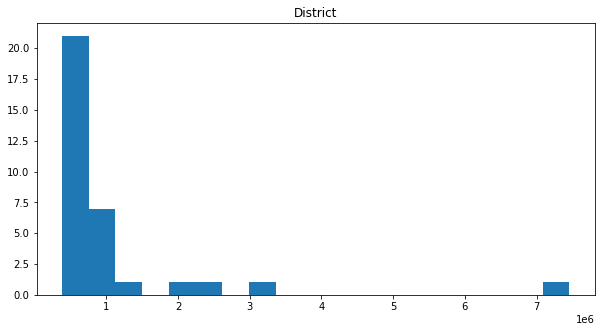

In [15]:
# Price distribution by borough district 
borough_prices = group_transactions(transactions_geo, 'District')
plot_hit_price(borough_prices)

(array([39., 18.,  8.,  3.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 363324.        ,  601969.31578947,  840614.63157895,
        1079259.94736842, 1317905.26315789, 1556550.57894737,
        1795195.89473684, 2033841.21052632, 2272486.52631579,
        2511131.84210526, 2749777.15789474, 2988422.47368421,
        3227067.78947368, 3465713.10526316, 3704358.42105263,
        3943003.73684211, 4181649.05263158, 4420294.36842105,
        4658939.68421053, 4897585.        ]),
 <BarContainer object of 19 artists>)

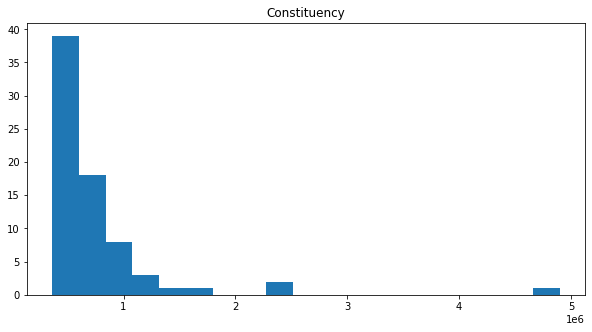

In [16]:
# Price distribution by consitunecies 
constituency_prices = group_transactions(transactions_geo, 'Constituency')
constituency_prices.head()
plot_hit_price(constituency_prices)

(array([264.,  15.,   4.,   4.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([3.04222000e+05, 8.89783979e+06, 1.74914576e+07, 2.60850754e+07,
        3.46786932e+07, 4.32723109e+07, 5.18659287e+07, 6.04595465e+07,
        6.90531643e+07, 7.76467821e+07, 8.62403999e+07, 9.48340177e+07,
        1.03427635e+08, 1.12021253e+08, 1.20614871e+08, 1.29208489e+08,
        1.37802107e+08, 1.46395724e+08, 1.54989342e+08, 1.63582960e+08]),
 <BarContainer object of 19 artists>)

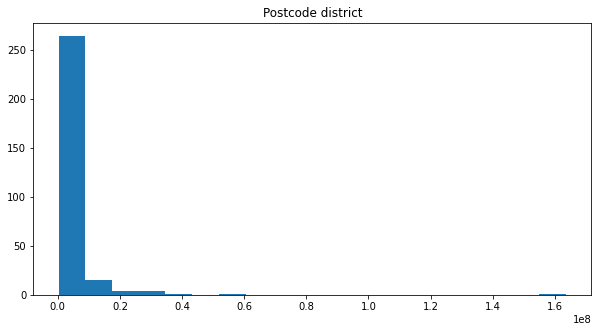

In [17]:
# Price distribution by postcode district
postcode_prices = group_transactions(transactions_geo, 'Postcode district')
plot_hit_price(postcode_prices)

In [18]:
# then  classify the prices into four bands expensive, premium, mid-range, cheap 
def price_classificaton(frame):
    lower = np.percentile(frame['avg_price'],25)
    median = np.percentile(frame['avg_price'],50)
    upper = np.percentile(frame['avg_price'],75)
    frame.loc[frame['avg_price'] > upper, 'price_band'] = 'expensive' 
    frame.loc[frame['avg_price'] <= upper, 'price_band'] = 'premium' 
    frame.loc[frame['avg_price'] <= median, 'price_band'] = 'mid-range' 
    frame.loc[frame['avg_price'] <= lower, 'price_band'] = 'cheap' 
    return frame

In [19]:
# create price classification
postcode_prices = price_classificaton(group_transactions(
    transactions_geo, 'Postcode district'))
constituency_prices = price_classificaton(group_transactions(
    transactions_geo, 'Constituency'))
distict_prices = price_classificaton(group_transactions(
    transactions_geo, 'District'))
postcode_prices.head()

,Postcode district,avg_price,price_band
0,BR1,578287,mid-range
1,BR2,513716,mid-range
2,BR3,532244,mid-range
3,BR4,553528,mid-range
4,BR5,473854,cheap


In [28]:
# Use foursquare to get London venues
CLIENT_ID = 'NFXW0WL3NAGWPUXGUNSE1WG4NFJQ5PXN1YGFRDUO5VOP23AC'
CLIENT_SECRET = 'W2BOXM13DKWQTV2OFGXM0QBSC2AC4JRCIPZYN3ZOD0H03D3W'
VERSION = '20180605'
LIMIT = 100

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
# postcode district
london_venues_postcode = getNearbyVenues(names=districts['Postcode district'],
                                   latitudes=districts['Latitude'],
                                   longitudes=districts['Longitude']
                                  )

BR1
BR2
BR3
BR4
BR5
BR6
BR7
BR8
CM13
CM14
CM23
CR0
CR2
CR3
CR4
CR44
CR5
CR6
CR7
CR8
CR9
CR90
DA1
DA14
DA15
DA16
DA17
DA18
DA5
DA6
DA7
DA8
E1
E10
E11
E12
E13
E14
E15
E16
E17
E18
E1W
E2
E20
E3
E4
E5
E6
E7
E77
E8
E9
E98
EC1A
EC1M
EC1N
EC1P
EC1R
EC1V
EC1Y
EC2A
EC2M
EC2N
EC2P
EC2R
EC2V
EC2Y
EC3A
EC3B
EC3M
EC3N
EC3P
EC3R
EC3V
EC4A
EC4M
EC4N
EC4P
EC4R
EC4V
EC4Y
EC50
EC88
EN1
EN2
EN3
EN4
EN5
EN6
EN7
EN8
EN9
HA0
HA1
HA2
HA3
HA4
HA5
HA6
HA7
HA8
HA9
IG1
IG11
IG2
IG3
IG4
IG5
IG6
IG7
IG8
IG9
KT1
KT17
KT18
KT19
KT2
KT22
KT3
KT4
KT5
KT6
KT7
KT8
KT9
N1
N10
N11
N12
N13
N14
N15
N16
N17
N18
N19
N1C
N1P
N2
N20
N21
N22
N3
N4
N5
N6
N7
N8
N81
N9
NW1
NW10
NW11
NW1W
NW2
NW26
NW3
NW4
NW5
NW6
NW7
NW8
NW9
RM1
RM10
RM11
RM12
RM13
RM14
RM15
RM2
RM3
RM4
RM5
RM50
RM6
RM7
RM8
RM9
SE1
SE10
SE11
SE12
SE13
SE14
SE15
SE16
SE17
SE18
SE19
SE1P
SE2
SE20
SE21
SE22
SE23
SE24
SE25
SE26
SE27
SE28
SE3
SE4
SE5
SE6
SE7
SE8
SE9
SE99
SM1
SM2
SM3
SM4
SM5
SM6
SM7
SW10
SW11
SW12
SW13
SW14
SW15
SW16
SW17
SW18
SW19
SW1A
SW1E
SW1H
SW1P
SW1

In [33]:
# consituencies
london_venues_consitutency= getNearbyVenues(names=consituencies['Constituency'],
                                   latitudes=consituencies['Latitude'],
                                   longitudes=consituencies['Longitude']
                                  )

Barking
Battersea
Beckenham
Bermondsey and Old Southwark
Bethnal Green and Bow
Bexleyheath and Crayford
Brent Central
Brent North
Brentford and Isleworth
Bromley and Chislehurst
Camberwell and Peckham
Carshalton and Wallington
Chelsea and Fulham
Chingford and Woodford Green
Chipping Barnet
Cities of London and Westminster
Croydon Central
Croydon North
Croydon South
Dagenham and Rainham
Dulwich and West Norwood
Ealing Central and Acton
Ealing North
Ealing, Southall
East Ham
Edmonton
Eltham
Enfield North
Enfield, Southgate
Erith and Thamesmead
Feltham and Heston
Finchley and Golders Green
Greenwich and Woolwich
Hackney North and Stoke Newington
Hackney South and Shoreditch
Hammersmith
Hampstead and Kilburn
Harrow East
Harrow West
Hayes and Harlington
Hendon
Holborn and St Pancras
Hornchurch and Upminster
Hornsey and Wood Green
Ilford North
Ilford South
Islington North
Islington South and Finsbury
Kensington
Kingston and Surbiton
Lewisham East
Lewisham West and Penge
Lewisham, Deptford
Le

In [34]:
# creat venues dataset by postcode district and consitutency
venues_postcode = london_venues_postcode
venues_consitutency = london_venues_consitutency
print(venues_postcode.shape)
print(venues_consitutency.shape)
venues_postcode.head(10)

(11352, 7)
(1288, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BR1,51.410733,0.019428,Cinnamon Culture,51.414196,0.020883,Indian Restaurant
1,BR1,51.410733,0.019428,Anglesey Arms,51.408703,0.020846,Pub
2,BR1,51.410733,0.019428,O'Neill's,51.407091,0.015784,Irish Pub
3,BR1,51.410733,0.019428,The Railway Tavern,51.407902,0.016725,Bar
4,BR1,51.410733,0.019428,Cow and Pig,51.407401,0.016438,English Restaurant
5,BR1,51.410733,0.019428,The Lavender House,51.414277,0.019808,Café
6,BR1,51.410733,0.019428,Crown & Anchor,51.407753,0.021074,Pub
7,BR1,51.410733,0.019428,Sundridge Park Railway Station (SUP),51.413742,0.021458,Train Station
8,BR1,51.410733,0.019428,Richer Sounds,51.407781,0.016678,Electronics Store
9,BR1,51.410733,0.019428,Buddha Kitchen,51.406448,0.019524,Buffet


In [35]:
# check venue categories
print(venues_postcode['Venue Category'].value_counts().head())
print(len(venues_postcode['Venue Category'].unique()))
# too many categories


Coffee Shop           726
Pub                   670
Café                  442
Hotel                 425
Italian Restaurant    342
Name: Venue Category, dtype: int64
372


In [36]:
# summary top venues in each postcode districts
def pre_processing(frame):
    london_one_hot = pd.get_dummies(frame[['Venue Category']], prefix="", prefix_sep="")
    london_one_hot['layer'] = frame['Neighborhood']
    london_grouped_category = london_one_hot.groupby('layer').mean().reset_index()
    return london_grouped_category


def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def get_top_venues(frame):
    num_top_venues = 10

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['layer']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    top_venues = pd.DataFrame(columns=columns)
    top_venues['layer'] = frame['layer']

    for ind in np.arange(frame.shape[0]):
        top_venues.iloc[ind, 1:] = return_most_common_venues(frame.iloc[ind, :], num_top_venues)
        
    return top_venues

In [38]:
#clustering postcode data
def elbow_method(frame):
    elbow_df = frame.drop('layer', 1)
#     elbow_df = frame
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=0).fit(elbow_df)
        distortions.append(sum(np.min(cdist(elbow_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / elbow_df.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('optimal k')
    plt.show()

In [39]:
# make kmeans_plot
def kmeans_plot(frame,k):
    hist_plot_df = frame.drop('layer', 1)
#     hist_plot_df = frame
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(hist_plot_df)
    plt.title(f'k={k}')
    # plot
    return plt.hist(kmeans.labels_, bins=k)

In [82]:
# make cluster folium map
def cluster_map(frame, k):
    # create map
    map_clusters = folium.Map(location=[51.5074, -0.1278],  tiles="cartodbpositron",zoom_start=11)

    # set color scheme for the clusters
    x = np.arange(k)
    ys = [i + x + (i*x)**2 for i in range(k)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(frame['Latitude'], frame['Longitude'], frame['layer'], frame['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=2,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

In [83]:
# view each cluster group dataframe
def view_df(frame, cluster):
    return frame.loc[frame['Cluster Labels'] == 
                     cluster, frame.columns[[0] + list(range(4, frame.shape[1]))]]

In [95]:
# regroup venues
Restaurant_msk = venues_postcode['Venue Category'].str.contains('Restaurant')
Bar_msk = venues_postcode['Venue Category'].str.contains('Bar')
Shop_msk = venues_postcode['Venue Category'].str.contains('Shop')
Store_msk = venues_postcode['Venue Category'].str.contains('Store')
Gym_msk = venues_postcode['Venue Category'].str.contains('Gym')
food_place_msk = venues_postcode['Venue Category'].str.contains('Place')
museum_msk = venues_postcode['Venue Category'].str.contains('Museum')

In [151]:
# make new venues catagries
def feature_engineering(frame):
    Restaurant_msk = frame['Venue Category'].str.contains('Restaurant')
    Bar_msk = frame['Venue Category'].str.contains('Bar')
    Shop_msk = frame['Venue Category'].str.contains('Shop')
    Store_msk = frame['Venue Category'].str.contains('Store')
    Gym_msk = frame['Venue Category'].str.contains('Gym')
    food_place_msk = frame['Venue Category'].str.contains('Place')
    museum_msk = frame['Venue Category'].str.contains('Museum')
    frame.loc[Restaurant_msk, 'Venue Category'] = 'Restaurant'
    frame.loc[Bar_msk, 'Venue Category'] = 'Bar'
    frame.loc[Shop_msk, 'Venue Category'] = 'Shop'
    frame.loc[Store_msk, 'Venue Category'] = 'Store'
    frame.loc[Gym_msk, 'Venue Category'] = 'Gym'
    frame.loc[food_place_msk, 'Venue Category'] = 'Place'
    frame.loc[museum_msk, 'Venue Category'] = 'Museum'
    return frame

In [152]:
# regroup venues 
venues_postcode = feature_engineering(venues_postcode)
len(venues_postcode['Venue Category'].unique())
venues_postcode
london_grouped = pre_processing(venues_postcode)
neighborhoods_venues_sorted = get_top_venues(london_grouped)

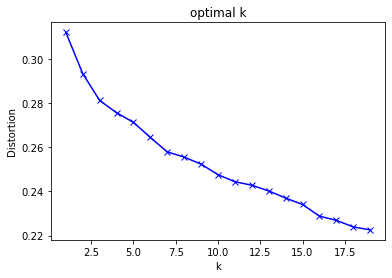

In [153]:
# find optimal k value by elbow_method
elbow_method(london_grouped)

In [154]:
# find optimal k value by elbow_method
k = 10
grouped_clustering = london_grouped.drop('layer', 1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(grouped_clustering)
labels = kmeans.labels_
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)
len(kmeans.labels_)

324

(array([  9.,  73., 131.,  60.,   1.,  24.,   3.,  16.,   1.,   6.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

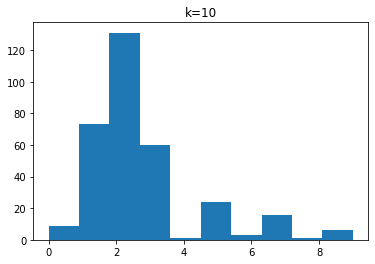

In [107]:
# check clustering with k =10
kmeans_plot(london_grouped, 10)

In [108]:
# make cluster_map
postcode_map = districts.merge(neighborhoods_venues_sorted,
                               left_on='Postcode district', right_on='layer')
cluster_map(postcode_map,k)

In [110]:
# merge with price dataset
postcode_cluster_prices = postcode_map.merge(postcode_prices, how='left', on='Postcode district')
postcode_cluster_prices.shape


(324, 17)

In [111]:
# check cluster1
view_df(postcode_cluster_prices,1).dropna()

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
0,BR1,BR1,Pub,Store,Restaurant,Irish Pub,Train Station,Bus Station,Café,Bar,Buffet,Dance Studio,578287.0,mid-range
15,CR5,CR5,Platform,Store,Restaurant,Yoga Studio,Diner,Film Studio,Farmers Market,Farm,Exhibit,Event Space,511727.0,mid-range
21,DA1,DA1,Store,Shop,Pub,Restaurant,Supermarket,Gym,Pharmacy,Construction & Landscaping,Exhibit,Community Center,378051.0,cheap
22,DA14,DA14,Store,Pub,Hotel,Shop,Bakery,Pharmacy,Restaurant,Design Studio,Farm,Exhibit,556276.0,mid-range
24,DA16,DA16,Shop,Restaurant,Supermarket,Pub,Place,Pharmacy,Store,Diner,Farm,Exhibit,381166.0,cheap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,W1K,W1K,Restaurant,Store,Shop,Bar,Hotel,Café,Place,Art Gallery,Lounge,Gym,7140625.0,expensive
290,W1S,W1S,Store,Restaurant,Shop,Boutique,Art Gallery,Bar,Hotel,Bookstore,Lounge,Tea Room,32546005.0,expensive
315,WC2E,WC2E,Shop,Restaurant,Store,Theater,Bakery,Bar,Burger Joint,Steakhouse,Plaza,Hotel,3514272.0,expensive
316,WC2H,WC2H,Shop,Restaurant,Store,Bar,Bakery,Theater,Hotel,Place,Lounge,Fried Chicken Joint,6891757.0,expensive


In [129]:
# check cluster2
view_df(postcode_cluster_prices,2).dropna()

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
2,BR3,BR3,Restaurant,Shop,Supermarket,Store,Park,Diner,Bar,Movie Theater,Café,Pharmacy,532244.0,mid-range
7,BR8,BR8,Diner,Café,Restaurant,Bar,Distillery,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,787500.0,premium
18,CR8,CR8,Restaurant,Shop,Place,Gym,Supermarket,Pharmacy,Pub,Platform,Convention Center,Design Studio,603827.0,mid-range
19,CR9,CR9,Restaurant,Store,Shop,Pub,Platform,Hotel,Place,Gym,Bookstore,Bar,15128611.0,expensive
36,E14,E14,Restaurant,Shop,Place,Bar,Plaza,Park,Hotel,Gym,Burger Joint,Street Food Gathering,848715.0,premium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,WC1V,WC1V,Restaurant,Shop,Pub,Place,Café,Bar,Store,Bookstore,Hotel,Park,20188216.0,expensive
312,WC1X,WC1X,Restaurant,Pub,Shop,Store,Place,Café,Bar,Garden,Hotel,Museum,2854131.0,expensive
313,WC2A,WC2A,Restaurant,Shop,Place,Pub,Hotel,Bar,Museum,Building,Theater,Burger Joint,2829222.0,expensive
314,WC2B,WC2B,Shop,Restaurant,Theater,Hotel,Store,Bar,Museum,Bakery,Bookstore,Pub,6147797.0,expensive


In [147]:
# check cluster3
view_df(postcode_cluster_prices,3).dropna()

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
1,BR2,BR2,Gym,Soccer Stadium,Athletics & Sports,Park,Distillery,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,513716.0,mid-range
3,BR4,BR4,Place,Supermarket,Pub,Store,Pharmacy,Restaurant,Design Studio,Farm,Exhibit,Event Space,553528.0,mid-range
11,CR2,CR2,Shop,Train Station,Park,Platform,Auto Garage,Yoga Studio,Farmers Market,Farm,Exhibit,Event Space,481578.0,cheap
12,CR3,CR3,Platform,Store,Garden Center,Yoga Studio,Distillery,Film Studio,Farmers Market,Farm,Exhibit,Event Space,481411.0,cheap
16,CR6,CR6,Gastropub,Place,Yoga Studio,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,Escape Room,778011.0,premium
32,E10,E10,Park,Fried Chicken Joint,Hotel,Farm,Shop,Cricket Ground,Store,Restaurant,Yoga Studio,Exhibit,439780.0,cheap
45,E5,E5,Shop,Store,Bar,Pub,Park,Restaurant,Bus Stop,Café,Fried Chicken Joint,Garden,606621.0,mid-range
46,E6,E6,Park,Café,Nature Preserve,Store,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,493263.0,mid-range
49,E8,E8,Pub,Restaurant,Shop,Bar,Gym,Gastropub,Lounge,Escape Room,Park,Pool,749936.0,premium
50,E9,E9,Pub,Store,Shop,Café,Gastropub,Deli / Bodega,Park,Place,Restaurant,Yoga Studio,639299.0,mid-range


In [131]:
# check cluster4
view_df(postcode_cluster_prices,4).dropna()

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band


In [146]:
# check cluster5
view_df(postcode_cluster_prices,5).dropna()

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
26,DA18,DA18,Restaurant,Place,Trail,Yoga Studio,Diner,Film Studio,Farmers Market,Farm,Exhibit,Event Space,1281974.0,premium
27,DA5,DA5,Restaurant,Tennis Court,Store,Cricket Ground,Yoga Studio,Film Studio,Farmers Market,Farm,Exhibit,Event Space,473172.0,cheap
34,E12,E12,Restaurant,Train Station,Pub,Concert Hall,Construction & Landscaping,Film Studio,Farmers Market,Farm,Exhibit,Event Space,420071.0,cheap
40,E18,E18,Restaurant,Store,Supermarket,Shop,Café,Bar,Multiplex,BBQ Joint,Metro Station,Pharmacy,525365.0,mid-range
82,EN1,EN1,Restaurant,Shop,Home Service,Supermarket,Design Studio,Farmers Market,Farm,Exhibit,Event Space,Escape Room,460407.0,cheap
99,HA8,HA8,Restaurant,Shop,Place,Store,Pharmacy,Supermarket,Bakery,Lounge,Bookstore,Deli / Bodega,560719.0,mid-range
107,IG6,IG6,Restaurant,Place,Shop,Store,Pharmacy,Pub,Athletics & Sports,Creperie,Farm,Exhibit,435038.0,cheap
109,IG8,IG8,Restaurant,Shop,Hotel,Home Service,Place,Store,Café,Metro Station,Yoga Studio,Diner,576911.0,mid-range
116,KT3,KT3,Restaurant,Store,Shop,Café,Place,Supermarket,Gym,Bar,Bookstore,Pub,629295.0,mid-range
155,NW4,NW4,Restaurant,Store,Shop,Place,Café,Irish Pub,Fried Chicken Joint,Plaza,Metro Station,Exhibit,652447.0,mid-range


In [133]:
# check cluster6
view_df(postcode_cluster_prices,6).dropna()

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
112,KT17,KT17,Park,Yoga Studio,Distillery,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,Escape Room,685833.0,premium
158,NW7,NW7,Park,Spa,Yoga Studio,Distillery,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,833299.0,premium


In [134]:
# check cluster7
view_df(postcode_cluster_prices,7).dropna()

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
5,BR6,BR6,Pub,Home Service,Store,Yoga Studio,Diner,Film Studio,Farmers Market,Farm,Exhibit,Event Space,554434.0,mid-range
6,BR7,BR7,Golf Course,Pub,Bar,Diner,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,652604.0,mid-range
10,CR0,CR0,Pub,Tram Station,Place,Diner,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,472365.0,cheap
17,CR7,CR7,Pub,Diner,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,Escape Room,Dry Cleaner,358808.0,cheap
23,DA15,DA15,Pub,Construction & Landscaping,Restaurant,Diner,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,412502.0,cheap
35,E13,E13,Pub,Café,Bus Station,Gym,Park,Distillery,Film Studio,Farmers Market,Farm,Exhibit,380307.0,cheap
44,E3,E3,Pub,Store,Road,Burger Joint,Bus Stop,Locksmith,Bar,Yoga Studio,Farmers Market,Farm,573767.0,mid-range
83,EN2,EN2,Pub,Hotel,Business Service,Distillery,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,563798.0,mid-range
110,IG9,IG9,Pub,Gym,Restaurant,Design Studio,Film Studio,Farmers Market,Farm,Exhibit,Event Space,Escape Room,560527.0,mid-range
113,KT19,KT19,Pub,Restaurant,Diner,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,Escape Room,325875.0,cheap


In [135]:
# check cluster8
view_df(postcode_cluster_prices,8).dropna()

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
218,SW15,SW15,Tennis Court,Yoga Studio,Food Court,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,782159.0,premium


In [136]:
# check cluster9
view_df(postcode_cluster_prices,9).dropna()

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
4,BR5,BR5,Construction & Landscaping,Shop,Bus Stop,Business Service,Concert Hall,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,473854.0,cheap
175,RM9,RM9,Construction & Landscaping,Yoga Studio,Distillery,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,347789.0,cheap
248,TW14,TW14,Construction & Landscaping,Bus Stop,Rental Service,Pub,Yoga Studio,Distillery,Film Studio,Farmers Market,Farm,Exhibit,440198.0,cheap
249,TW15,TW15,Construction & Landscaping,Yoga Studio,Distillery,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,327000.0,cheap
261,UB11,UB11,Construction & Landscaping,Soccer Field,Bus Stop,Yoga Studio,Dry Cleaner,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,25200000.0,expensive


In [137]:
# check cluster10
view_df(postcode_cluster_prices,10).dropna()

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band


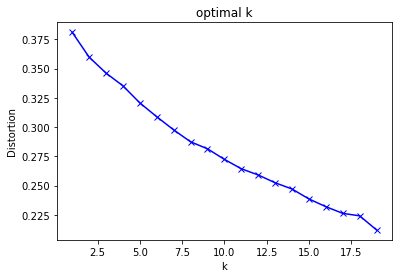

In [155]:
#use same method to make clustering analysis at consituency level

constits = london_venues_consitutency.copy()
# constits = pd.read_csv('constituency_venues.csv')
constits = feature_engineering(constits)
constits_one_hot = pre_processings_(constits)
elbow_method(constits_one_hot)

(array([39.,  7.,  1.,  1.,  8., 15.,  1.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

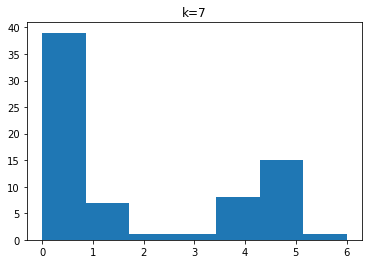

In [156]:
# check clustering with k =7
kmeans_plot(constits_one_hot, 7)

In [157]:
# k =7
constit_venues_sorted = get_top_venues(constits_one_hot)
k = 7
constits_one_hot = constits_one_hot.drop('layer', 1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(constits_one_hot)
labels = kmeans.labels_
constit_venues_sorted.insert(0, 'Cluster Labels', labels)


In [127]:
# make cluster map
boroughs_map_df = consituencies.merge(constit_venues_sorted, left_on='Constituency', right_on='layer')
cluster_map(boroughs_map_df,k)